In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import keras
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.datasets import cifar10
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# convert from color image (RGB) to grayscale
# source: opencv.org
# grayscale = 0.299*red + 0.587*green + 0.114*blue
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


In [ ]:
# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_val = x_train[45000:50000,:,:,:]
y_val = y_train[45000:50000,:]

x_train = x_train[:45000,:,:,:]
y_train = y_train[:45000,:]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')
print(x_test.shape[0], 'test samples')
print(y_train[0])

x_train shape: (45000, 32, 32, 3)
45000 train samples
5000 val samples
10000 test samples
[6]


In [ ]:

# input image dimensions
# we assume data format "channels_last"
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]

# create saved_images folder
imgs_dir = '/content/drive/My Drive/Colab Notebooks/Colorization Autoencoder/saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

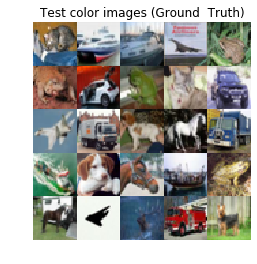

In [ ]:
# display the 1st 100 input images (color and gray)
imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [ ]:
# convert color train and test images to gray
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)
x_val_gray = rgb2gray(x_val)

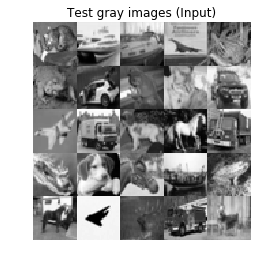

In [ ]:
# display grayscale version of test images
imgs = x_test_gray[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test gray images (Input)')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('%s/test_gray.png' % imgs_dir)
plt.show()


In [ ]:
# normalize output train and test color images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_val = x_val.astype('float32') / 255

# normalize input train and test grayscale images
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255
x_val_gray = x_val_gray.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, channels)

# reshape images to row x col x channel for CNN input
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)
x_val_gray = x_val_gray.reshape(x_val_gray.shape[0], img_rows, img_cols, 1)

In [ ]:
# network parameters
input_shape = (img_rows, img_cols, 1)
batch_size = 32
epochs = 30
kernel_size = 3
latent_dim = 256
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [64, 96, 128]


In [ ]:
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Conv2D(64)-Conv2D(128)-Conv2D(256)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

# shape info needed to build decoder model so we don't do hand computation
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (4, 4, 256) which is processed by the decoder back to (32, 32, 3)
shape = K.int_shape(x)

# generate a latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 96)          55392     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 4, 4, 128)         110720    
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 256)               524544    
Total params: 691,296
Trainable params: 691,296
Non-trainable params: 0
_____________________________________________________

In [ ]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# stack of Conv2DTranspose(256)-Conv2DTranspose(128)-Conv2DTranspose(64)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=channels,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              526336    
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 16, 16, 96)        110688    
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 32, 32, 64)        55360     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         1731

In [ ]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 256)               691296    
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         841699    
Total params: 1,532,995
Trainable params: 1,532,995
Non-trainable params: 0
_________________________________________________________________


In [ ]:
 #prepare model saving directory.
save_dir = os.path.join(os.getcwd(), '/content/drive/My Drive/Colab Notebooks/Colorization Autoencoder/saved_models')
model_name = 'colorized_ae_model.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [ ]:

# reduce learning rate by sqrt(0.5) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.5),
                               cooldown=0,
                               patience=3,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

In [ ]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

# called every epoch
callbacks = [lr_reducer, checkpoint]

In [ ]:
# train the autoencoder
H = autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_val_gray, x_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 30s 658us/step - loss: 0.0155 - val_loss: 0.0108

Epoch 00001: val_loss improved from inf to 0.01085, saving model to /content/drive/My Drive/Colab Notebooks/Colorization Autoencoder/saved_models/colorized_ae_model.h5
Epoch 2/30
45000/45000 [==============================] - 28s 629us/step - loss: 0.0102 - val_loss: 0.0095

Epoch 00002: val_loss improved from 0.01085 to 0.00952, saving model to /content/drive/My Drive/Colab Notebooks/Colorization Autoencoder/saved_models/colorized_ae_model.h5
Epoch 3/30
45000/45000 [==============================] - 28s 630us/step - loss: 0.0092 - val_loss: 0.0088

Epoch 00003: val_loss improved from 0.00952 to 0.00880, saving model to /content/drive/My Drive/Colab Notebooks/Colorization Autoencoder/saved_models/colorized_ae_model.h5
Epoch 4/30
45000/45000 [==============================] - 28s 623us/step - loss: 0.0086 - val_loss: 0.0083

Epoch 0

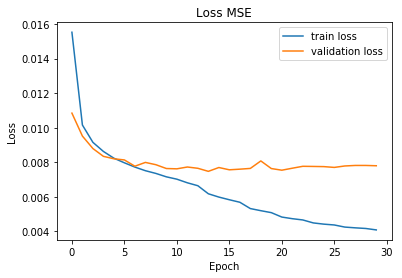

In [ ]:
fig = plt.figure()
numOfEpoch = epochs
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='train loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.title('Loss MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

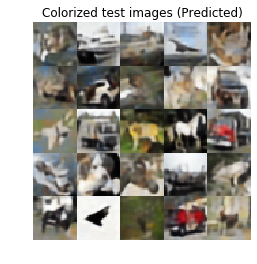

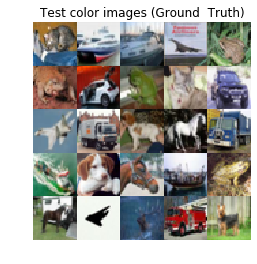

In [ ]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test_gray)

# display the 1st 100 colorized images
imgs = x_decoded[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()

imgs = x_test[:25]
imgs = imgs.reshape((5, 5, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs, interpolation='none')
plt.show()